Produce regression tables and figures for whole sample and sub samples to test Morris and Shin hypothesis.

In [1]:
# Initial imports 
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
import datetime as dt
directory = 'C:/Users/tmund/Documents/Submissions/HigherMomentsRep/'
os.chdir(directory)

In [2]:
mypath = 'DataVis/MS/Figs/'

In [3]:
# Import data
SurveyShock = pd.read_pickle('Output/7 - Shocks/ReutersSurveyShock.pkl')

In [4]:
# Morris and Shin analysis
# i.e. previous surveys have effect on shock as CB chooses shock level to deliver

In [5]:
# Surveys have effect on subsequent shock
# Regressions:
    # RHS: Surveys - levels, changes and lags
    # LHS: Shocks - both specifications
# Full sample
    
startdate = pd.to_datetime('20080101', format='%Y%m%d', errors='ignore') 
enddate = pd.to_datetime('20140101', format='%Y%m%d', errors='ignore')
survey_list_ms = ['StDev_sur',
                  'Range_sur']

shock_list_ms = ['StDevresid_shock',
                'StDevresid_fitted_ir_shock']

coeff_dict_ms = {}

for shock_measure in shock_list_ms:
    SurveyShockNoNaMS = SurveyShock.copy()
    SurveyShockNoNaMS[shock_measure] = SurveyShockNoNaMS.loc[:, shock_measure].shift(-1) # get t plus 1 shock
    SurveyShockNoNaMS = SurveyShockNoNaMS.loc[startdate:enddate, :].copy() # only keep subsample
    for survey_measure in survey_list_ms:
        SurveyShockNoNaMS = SurveyShockNoNaMS.loc[SurveyShockNoNaMS[survey_measure].isna()==False, :] # only keep lines with surveys in
        SurveyShockNoNaMS['StDev_sur_chg'] = SurveyShockNoNaMS['StDev_sur'].diff(1) # create change variables
        SurveyShockNoNaMS['Range_sur_chg'] = SurveyShockNoNaMS['Range_sur'].diff(1)
        X = pd.DataFrame(index = SurveyShockNoNaMS.index)
        X = sm.add_constant(X, prepend=True)
        y = SurveyShockNoNaMS.loc[:, shock_measure].copy()
        for i in range(0, 5): # go from zero here as you can have "contemporaneous" variables in this survey given structure of df
            X[survey_measure+str('_')+str(i)] = SurveyShockNoNaMS.loc[:, survey_measure].copy().shift(i)
            model = sm.OLS(y, X, missing='drop')
            res = model.fit()
            coeff_dict_ms[str(shock_measure)
                          +str(survey_measure)
                          +str('_')
                          +str(i)] = pd.DataFrame(data={'coeffs':res.params,
                                                        'tvalues':res.tvalues})

In [6]:
coeff_dict_ms['StDevresid_fitted_ir_shockStDev_sur_0']

,coeffs,tvalues
const,0.007303,3.368620
StDev_sur_0,-0.027117,-3.262721


In [7]:
coeff_dict_ms['StDevresid_fitted_ir_shockRange_sur_0']

,coeffs,tvalues
const,0.007198,2.937245
Range_sur_0,-0.005941,-2.745967


In [8]:
# For now just write these out.

In [10]:
# Do a rolling regression to get a sense of shape

def rolling(survey_measure, shock_measure, periods, label):
    coeff_array=np.zeros(periods)
    t_array = np.zeros(periods)
    
    i = 0
    startdate = pd.to_datetime('19980101', format='%Y%m%d', errors='ignore') 
    enddate = pd.to_datetime('20040101', format='%Y%m%d', errors='ignore') 
    while i<periods:
        SurveyShockNoNaMS = SurveyShock.copy()
        SurveyShockNoNaMS[shock_measure] = SurveyShockNoNaMS.loc[:, shock_measure].shift(-1) # get t plus 1 shock
        SurveyShockNoNaMS = SurveyShockNoNaMS.loc[startdate:enddate, :].copy() # only keep subsample
        SurveyShockNoNaMS['StDev_sur_chg'] = SurveyShockNoNaMS['StDev_sur'].diff(1) # create change variables
        SurveyShockNoNaMS['Range_sur_chg'] = SurveyShockNoNaMS['Range_sur'].diff(1)
        SurveyShockNoNaMS = SurveyShockNoNaMS.loc[SurveyShockNoNaMS[survey_measure].isna()==False, :] # only keep lines with surveys in
        X = pd.DataFrame(index = SurveyShockNoNaMS.index)
        X = sm.add_constant(X, prepend=True)
        y = SurveyShockNoNaMS.loc[:, shock_measure].copy()
        X[survey_measure] = SurveyShockNoNaMS.loc[:, survey_measure].copy() # only "contemporaneous", no lags
        model = sm.OLS(y, X, missing='drop')
        res = model.fit()
        coeff_array[i] = res.params[1]
        t_array[i] =res.tvalues[1]

        startdate = startdate + pd.Timedelta(30.4, unit='D')
        enddate = enddate + pd.Timedelta(30.4, unit='D')
        i += 1
    #print(startdate)
    print(enddate)
    dateaxis = pd.date_range(start = pd.to_datetime('19980101', format='%Y%m%d', errors='ignore'), 
                            periods=periods,
                            freq='M')
    #plt.figure(figsize=(8, 6))
    plt.plot(dateaxis,t_array, label=label)
    plt.xlabel('Starting year for rolling regression')
    plt.ylabel('t-values')
    plt.hlines(-1.96, xmin =pd.to_datetime('19980101', format='%Y%m%d', errors='ignore'),
               xmax = pd.to_datetime('20140101', format='%Y%m%d', errors='ignore'),
               colors='k', linestyle='dashed')
    plt.legend()
    #plt.savefig(mypath+str(survey_measure)+str('rolling.pdf'))
    #plt.show()
    return None

2018-12-25 00:00:00
2018-12-25 00:00:00


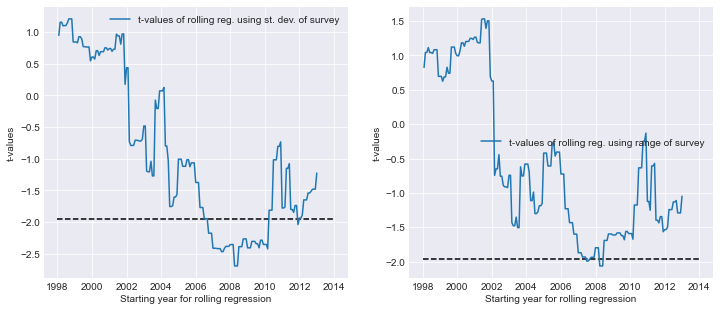

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
rolling('StDev_sur', 'StDevresid_shock', 180, 't-values of rolling reg. using st. dev. of survey')

plt.subplot(1, 2, 2)
rolling('Range_sur', 'StDevresid_shock', 180, 't-values of rolling reg. using range of survey')

#plt.savefig(mypath+str('rolling.pdf'))
plt.show()